In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Note EWKino_CLs_train.csv and EWKino_CLs_test.csv are already normalised to mean=0 and std=1 on every column that isn't CLs
train = pd.read_csv("csv-files/EWKino_CLs_train.csv")

2024-12-02 15:32:46.977446: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 15:32:47.507564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 15:32:49.116174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
def custom_loss(y_true, y_pred):
    # Calculate normal squared error
    squared_error = tf.square(y_true - y_pred)
    
    # Apply weight to focus on values close to zero
    weighted_squared_error = squared_error * (1-0.5*y_true)
    
    # Return weighted MSE as loss
    loss = tf.reduce_mean(weighted_squared_error)
    return loss

In [ ]:
def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.005),
        loss=custom_loss,
        metrics=["mae"]
    )
    
    return model

In [79]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    # Shuffle the entire training dataset
    shuffled_df = df.sample(frac=1)
    
    # Separate the inputs and target outputs into train and labels respectively
    labels = shuffled_df.pop("Final__CLs")
    train = shuffled_df
    num_val_samples = len(train) // k
    all_histories = []
    
    for i in range(k):
        # print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_mae"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["mae"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy

In [82]:
k = 2 # This value seems to work fine
num_epochs = 500 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 1 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, train)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

Processing iteration #0


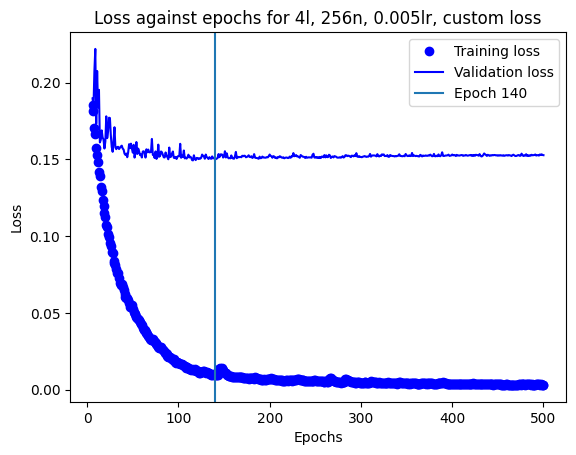

In [ ]:
# Plot training and validation accuracy for each epoch

best_epoch = 140
cut = 5
epochs = range(cut+1, num_epochs + 1)
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training loss")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation loss")
plt.axvline(best_epoch, label=f"Epoch {best_epoch}")
plt.title("Loss against epochs for 4l, 256n, 0.005lr, custom loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("custom_loss_fitting_data_CLs_500_epochs.png")
plt.show()

In [88]:
# Train new model on all of the available data
# Best epoch for this model is 140

df = pd.read_csv("csv-files/EWKino_CLs_train.csv")
labels = df.pop("Final__CLs")
train = df

model = build_model()
        
history = model.fit(
    train,
    labels,
    epochs=140, # Change this depending on when the model starts overfitting
    verbose=0
)

In [89]:
# Read in the test file that the model has not seen
test = pd.read_csv("csv-files/EWKino_CLs_test.csv")

# Store the ground truth we are hoping to predict in targets
targets = test.pop("Final__CLs").values

# Predict the DM relic densities using our model. Using .flatten() turns predictions into a 1D array that can be put into a dataframe
predictions = model.predict(test).flatten()

data = {'Targets': targets,
        'Predictions': predictions}

# Save the predictions of the model
comparison_df = pd.DataFrame(data)
comparison_df.to_csv("csv-files/CLs_predictions_vs_targets_4l_256n_0.005lr_custom_loss.csv", index=False)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
